<a href="https://colab.research.google.com/github/sarahlai30/Machine-Learning-INDE-577/blob/main/Unsupervised%20Learning/DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DBSCAN Clustering**

DBSCAN is a popular clustering algorithm in machine learning that identifies clusters in a dataset based on the density of points. It works by grouping points that are close to each other and labeling points far from any cluster as noise or outliers. This makes DBSCAN highly effective for tasks like outlier detection and data cleaning.


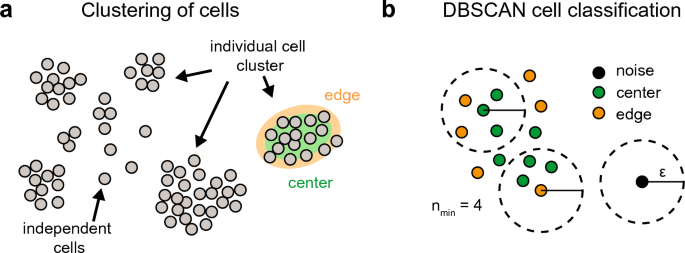

DBSCAN revolves around three key concepts:

1. Center Points: A point with at least MinPts neighboring points within a distance ε. Core points are central to forming clusters.

2. Edge Points: A point within ε distance of a core point but having fewer than MinPts neighbors itself.
An edge point is included in a cluster but cannot expand the cluster on its own.

3. Noise Points: Points that are neither core points nor border points.
They are considered outliers and remain unassigned to any cluster.


DBSCAN uses two main parameters:

*   **ε (epsilon)** defines the maximum distance between two points for them to be considered neighbors.
Larger values result in fewer but larger clusters, while smaller values form more compact clusters.

*   **MinPts** specifies the minimum number of points required to form a cluster.
A higher MinPts requires denser regions to form clusters.

By adjusting these parameters, you can control how the algorithm defines clusters, allowing it to adapt to different types of datasets and clustering requirements.

---

How Does DBSCAN Work?
DBSCAN operates by examining the neighborhood of each point in the dataset. Let's break down how DBSCAN works:

1. Parameter Selection:
Choose ε and MinPts

2. Select a Starting Point: Begin with an arbitrary unvisited point from the dataset.

3. Examine the Neighborhood

 Retrieve all points within the ε distance of the starting point.
*   If the number of points is less than MinPts, mark it as noise (for now).
*   If the number of points is at least MinPts, mark it as a core point and create a new cluster.

4. Expand the Cluster: Include all neighboring points in the cluster.

For each of these neighbors:

*   If the neighbor is a core point, expand the cluster recursively by examining its neighbors.
*   If it's not a core point, it's marked as a **border point**.

5. Repeat the Process:
Move to the next unvisited point in the dataset.
Steps 3-4 are repeated until all points have been visited.

6. Finalize Clusters
After all points have been processed, all clusters are finalized.
Points initially labeled as noise may be reassigned to clusters if they are within ε of a core point.

7. Handling Noise: Points that remain unassigned after all iterations are definitively labeled as noise or outliers.

DBSCAN is well-suited for identifying clusters of varying shapes in datasets with noise and outliers. Its ability to detect dense regions while ignoring sparse, scattered points makes it ideal for tasks like **anomaly detection, geospatial analysis, and customer segmentation.** Unlike algorithms such as K-Means, DBSCAN doesn’t require specifying the number of clusters in advance, making it useful for exploratory data analysis.

In this notebook, we will be using the Mall Customers dataset to perform customer segmentation by clustering customers based on their Annual Income (k$) and Spending Score (1-100). This segmentation can help businesses understand customer behavior, enabling targeted marketing campaigns, personalized offers, and better resource allocation.

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# Upload file
uploaded = files.upload()
import pandas as pd

df = pd.read_csv('Mall_Customers.csv')


Saving Mall_Customers.csv to Mall_Customers.csv


Before we do anything, we make sure to scale the features because clustering algorithms like DBSCAN and K-Means are distance-based and sensitive to feature magnitudes. Scaling ensures that Annual Income and Spending Score contribute equally when calculating distances.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
X_train = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


Defining our function region_query to perform the neighborhood query step in DBSCAN.
The function finds all points in the dataset X that are within the distance eps from a given point point_idx.

In [ ]:
def region_query(X, point_idx, eps):
    distances = euclidean_distances([X[point_idx]], X)[0]
    return [i for i, dist in enumerate(distances) if dist <= eps]


Then our function to perform cluster expansion. The function builds the cluster by recursively checking neighbors and adding points that meet the minimum density criteria (min_samples).

In [ ]:
def expand_cluster(X, point_idx, neighbors, labels, cluster_id, eps, min_samples):

    labels[point_idx] = cluster_id
    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]
        if labels[neighbor_idx] == -1:  # Noise becomes part of the cluster
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == 0:  # Unvisited point
            labels[neighbor_idx] = cluster_id
            # Find neighbors of the neighbor point
            new_neighbors = region_query(X, neighbor_idx, eps)
            if len(new_neighbors) >= min_samples:
                neighbors += new_neighbors
        i += 1
    return labels


Now putting it all together, our dbscan function clusters data points based on density and labels points as either core points, border points, or noise.

In [ ]:
def dbscan(X, eps, min_samples):
    n_samples = X.shape[0]
    labels = [0] * n_samples  # 0 means unvisited
    cluster_id = 0

    for i in range(n_samples):  # External loop
        if labels[i] != 0:  # Skip already visited points
            continue
        neighbors = region_query(X, i, eps)
        if len(neighbors) < min_samples:
            labels[i] = -1  # Mark as noise
        else:
            cluster_id += 1
            labels = expand_cluster(X, i, neighbors, labels, cluster_id, eps, min_samples)

    return labels


Now we can label our clusters in the Mall Customers dataset using the DBSCAN algorithm. Each customer is assigned a cluster ID based on their Annual Income and Spending Score. A "-1" indicates noise or an outlier who are customers whose spending patterns do not fit into any cluster.

In [ ]:
eps = 0.5  # Maximum distance for neighbors
min_samples = 5  # Minimum number of neighbors to form a dense region
dbscan_labels = dbscan(X_train_scaled, eps, min_samples)

# Add DBSCAN labels to the DataFrame
df['DBSCAN_Cluster'] = dbscan_labels
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   DBSCAN_Cluster  
0               1  
1               1  
2               1  
3               1  
4               1  


Visualizing our clusters so we can get a better look:

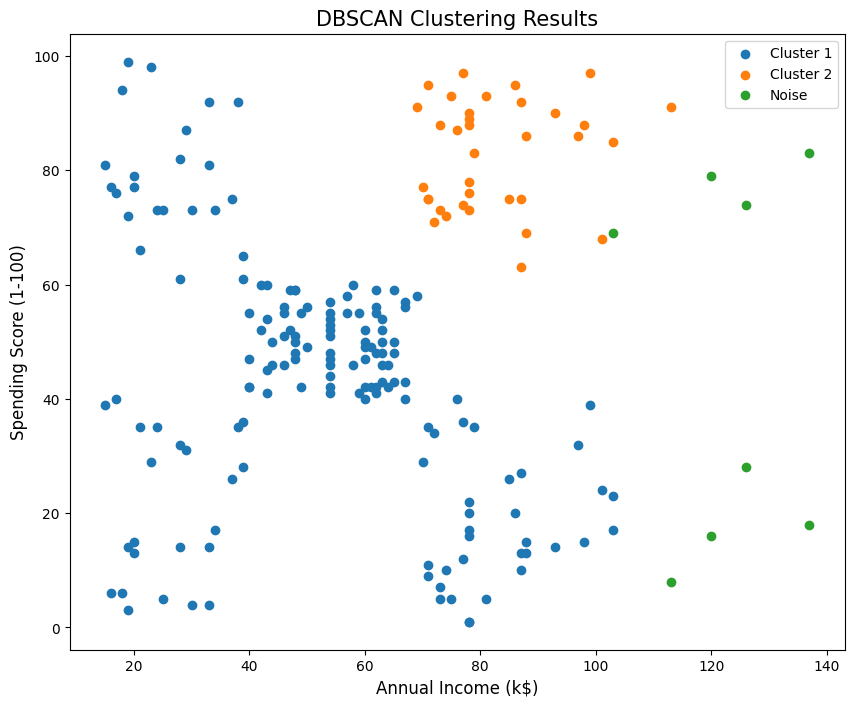

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
unique_labels = set(dbscan_labels)
for cluster_id in unique_labels:
    cluster_points = X_train[np.array(dbscan_labels) == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}' if cluster_id != -1 else 'Noise')
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.title('DBSCAN Clustering Results', fontsize=15)
plt.legend()
plt.show()

From the plot, we can see that Cluster 1 represents low-to-moderate spenders across a wide range of incomes, likely showing a conservative spending pattern.
Cluster 2 represents high spenders, likely customers who could be targeted with premium or high-value offers. Noise points could indicate unique customer behaviors or errors in data that require further investigation.

DBSCAN identified clusters of arbitrary shapes, with Cluster 1 being more scattered and Cluster 2 more concentrated. This shows the algorithm’s strength in handling non-spherical clusters.

We can further improve DBSCAN by combining it with K-Nearest Neighbors (KNN) to improve the clustering results and predictions. In the next code block we remove the noise points from the training data. By removing these points, we ensure that the training set contains only valid clusters, improving the reliability of subsequent predictions.

To evaluate the performance of KNN predictions, we split the data into training and testing sets to properly evaluate the KNN model on unseen data while preventing overfitting.

In [ ]:
from sklearn.model_selection import train_test_split

# Remove noise points (-1) from the training set
valid_points = [i for i, label in enumerate(dbscan_labels) if label != -1]
X_train_valid = X_train_scaled[valid_points]
y_train_valid = np.array([dbscan_labels[i] for i in valid_points])

# Split the data into training and testing sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train_valid, y_train_valid, test_size=0.2, random_state=42
)

Using our same KNN functions from the KNN notebook:

In [ ]:
def distance(p, q):
    return np.sqrt(np.sum((p - q) ** 2))

# KNN helper function to find nearest labels
def k_nearest_neighbors(point, training_features, training_labels, k):
    distances = []

    for p, label in zip(training_features, training_labels):
        d = distance(point, p)
        distances.append((label, d))

    # Sort by distance and return the k closest neighbors
    distances.sort(key=lambda x: x[1])
    return distances[:k]

# KNN prediction function
def KNN_Predict(point, training_features, training_labels, k, regression=False):
    neighbors = k_nearest_neighbors(point, training_features, training_labels, k)

    if not regression:
        labels = [label for label, _ in neighbors]
        return max(set(labels), key=labels.count)
    else:
        labels = [label for label, _ in neighbors]
        return sum(labels) / k

We predict labels for all points, including those initially labeled as noise by DBSCAN, so that they are assigned a cluster. This creates a more complete and interpretable segmentation of the data.


In [ ]:
k = 3  # Number of nearest neighbors
y_knn_pred = []

for point in X_train_scaled:  # Loop over all data points
    pred_label = KNN_Predict(point, X_train_valid, y_train_valid, k)
    y_knn_pred.append(pred_label)

# Add the predicted labels to the DataFrame
df['KNN_Cluster'] = y_knn_pred

# Display the updated DataFrame
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   DBSCAN_Cluster  KNN_Cluster  
0               1            1  
1               1            1  
2               1            1  
3               1            1  
4               1            1  


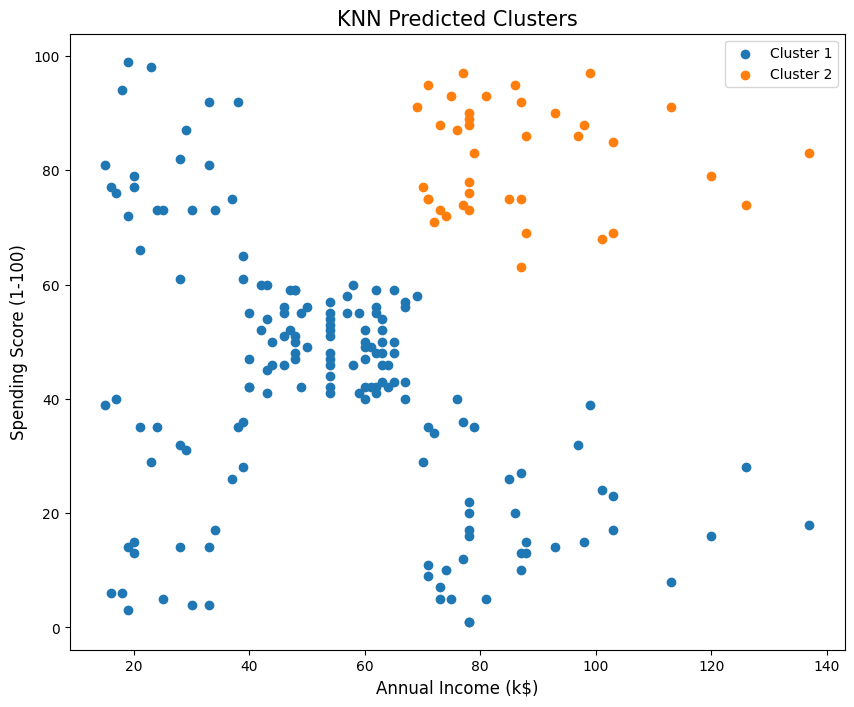

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
unique_labels = set(y_knn_pred)
for cluster_id in unique_labels:
    cluster_points = X_train[np.array(y_knn_pred) == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}' if cluster_id != -1 else 'Noise')
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.title('KNN Predicted Clusters', fontsize=15)
plt.legend()
plt.show()


KNN has successfully distinguished high spenders (Cluster 2) from general spenders (Cluster 1), providing clear separation between the two groups. Unlike DBSCAN, KNN assigns every data point to a cluster, including those previously identified as noise, by leveraging proximity to neighboring points. This approach results in smoother and more cohesive cluster boundaries, thanks to the majority voting mechanism of KNN.

However, a notable limitation of KNN is its handling of outliers. Unlike DBSCAN, which effectively identifies and excludes outliers, KNN assigns all points to clusters, even those that may not fit well into any group. This can occasionally compromise the representation of distinct data points.